# Handwriting Recognizer

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers

from emnist import extract_training_samples, extract_test_samples

In [2]:
# Import data
# Datasets are available from https://www.kaggle.com/datasets/crawford/emnist
train_df = pd.read_csv('emnist-balanced-train.csv',header=None).rename(columns={0:'ID'})
train_df.columns = train_df.columns.map(str)
test_df = pd.read_csv('emnist-balanced-test.csv',header=None).rename(columns={0:'ID'})
test_df.columns = test_df.columns.map(str)

In [3]:
# Mapping for labels
# Mapping file is available from https://www.kaggle.com/datasets/crawford/emnist
mapping_df = pd.read_csv('emnist-balanced-mapping.txt',header=None)
mapping_df[0]=mapping_df[0].apply(lambda x: chr(int(x.split(' ')[1])))
mapping_df = mapping_df.rename(columns={0:'Label'})
mapping_df

,Label
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


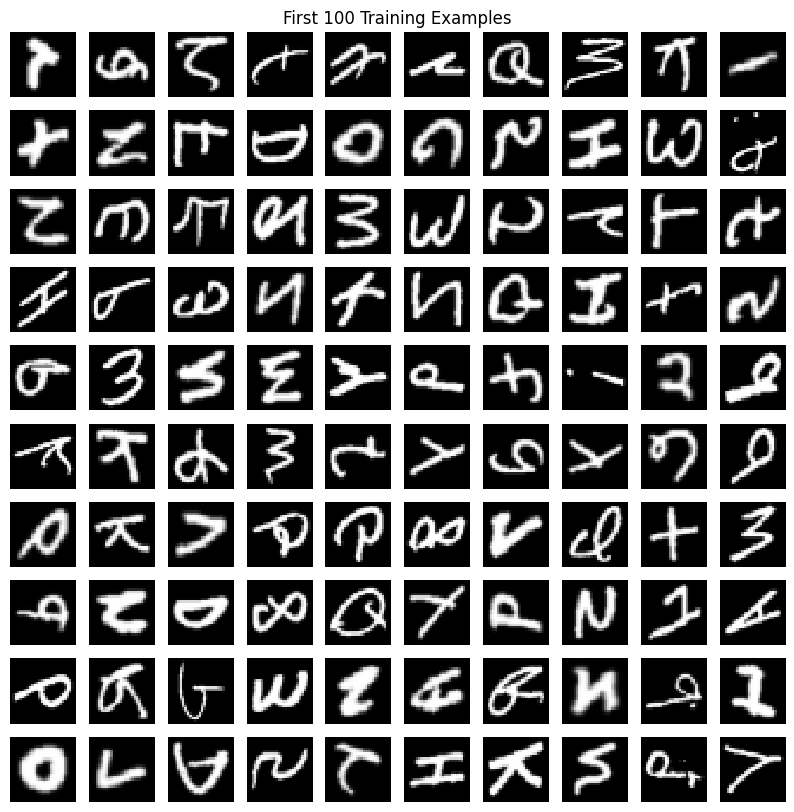

In [4]:
# Display the first 100 Training Examples

fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
plt.title('First 100 Training Examples')

for i in range(100):
    fig.add_subplot(10,10,i+1)
    plt.imshow(train_df.iloc[i,1:].astype(float).values.reshape(28,28),interpolation='nearest',cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
# Process the data

X_train = train_df.copy()
y_train = train_df.pop('ID')

X_test = test_df.copy()
y_test = test_df.pop('ID')

features = list(X_train.columns[1:])

transformer = make_pipeline(
    MinMaxScaler(),
)

preprocessor = make_column_transformer(
    (transformer, features),
)


X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
y_train = keras.utils.to_categorical(y_train, 47)
y_test = keras.utils.to_categorical(y_test, 47)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# Define the model

model = Sequential([
    layers.BatchNormalization(),
    layers.Dense(784, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(47, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Epoch 1/100
882/882 [==============================] - 9s 10ms/step - loss: 1.4900 - accuracy: 0.5777 - val_loss: 0.6738 - val_accuracy: 0.7814
Epoch 2/100
882/882 [==============================] - 9s 10ms/step - loss: 0.8250 - accuracy: 0.7409 - val_loss: 0.5591 - val_accuracy: 0.8162
Epoch 3/100
882/882 [==============================] - 9s 10ms/step - loss: 0.6952 - accuracy: 0.7765 - val_loss: 0.5134 - val_accuracy: 0.8294
Epoch 4/100
882/882 [==============================] - 9s 11ms/step - loss: 0.6278 - accuracy: 0.7962 - val_loss: 0.4833 - val_accuracy: 0.8403
Epoch 5/100
882/882 [==============================] - 9s 10ms/step - loss: 0.5816 - accuracy: 0.8100 - val_loss: 0.4658 - val_accuracy: 0.8449
Epoch 6/100
882/882 [==============================] - 8s 10ms/step - loss: 0.5463 - accuracy: 0.8190 - val_loss: 0.4559 - val_accuracy: 0.8479
Epoch 7/100
882/882 [==============================] - 9s 10ms/step - loss: 0.5186 - accuracy: 0.8269 - val_loss: 0.4481 - val_accuracy:

<AxesSubplot: title={'center': 'Accuracy'}>

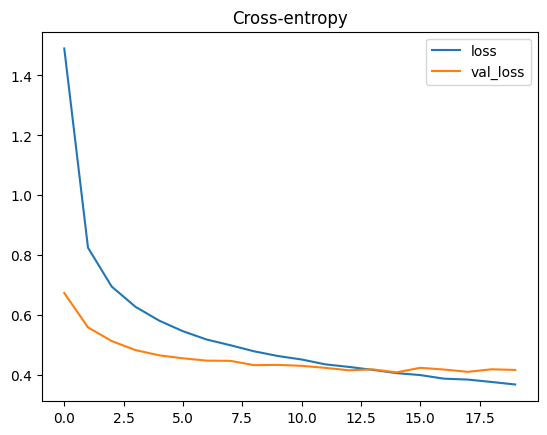

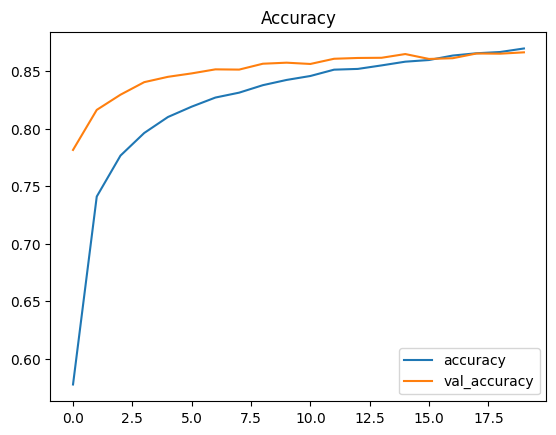

In [9]:
# Train the model

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping],
)
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")